In [ ]:
! ls "/content/drive/MyDrive/image classification-braintumor"


Testing  Training


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [ ]:
# Function for inporting data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels

In [ ]:
# Setting up file paths for training and testing
USER_PATH = r"/content/drive/MyDrive/image classification-braintumor"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5722
Number of Labels: 5722

Testing
Number of Paths: 1321
Number of Labels: 1321


x reshaped: (1, 150, 150, 3)


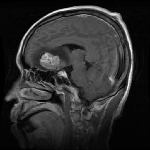

In [ ]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5722 images belonging to 4 classes.
Found 1321 images belonging to 4 classes.


In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 41


In [ ]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)

    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")

        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)

    plt.tight_layout()
    plt.show()


# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
# Define the model architecture
model_2 = models.Sequential()

# Convolutional layer 1
model_2.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_2.add(Conv2D(64, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3))) #

# Convolutional layer 4
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(Flatten())

# Full connect layers
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.5, seed=SEED))
model_2.add(Dense(N_TYPES, activation="softmax"))

model_2.summary()


optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_2_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_2_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history_2 = model_2.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps,
                        callbacks=[model_2_es, model_2_rlr])

Epoch 1/40
178/178 [==============================] - 2817s 16s/step - loss: 0.8229 - accuracy: 0.6232 - val_loss: 0.7760 - val_accuracy: 0.7165 - lr: 0.0010
Epoch 2/40
178/178 [==============================] - 61s 345ms/step - loss: 0.4957 - accuracy: 0.8021 - val_loss: 0.6661 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 3/40
178/178 [==============================] - 57s 319ms/step - loss: 0.3988 - accuracy: 0.8439 - val_loss: 0.7266 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 4/40
178/178 [==============================] - 59s 330ms/step - loss: 0.3248 - accuracy: 0.8750 - val_loss: 0.4362 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 5/40
178/178 [==============================] - 57s 319ms/step - loss: 0.2489 - accuracy: 0.9081 - val_loss: 0.2369 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 6/40
178/178 [==============================] - 55s 307ms/step - loss: 0.2002 - accuracy: 0.9262 - val_loss: 0.2510 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 7/40
178/178 [==============================] 

In [ ]:
model_2.save('braintumor_model_gpu_2.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

CLASS_TYPES = [ 'glioma','meningioma', 'notumor', 'pituitary']
model = load_model('/content/braintumor_model_gpu_1.h5')
Img_file = "/content/Te-glTr_0000.jpg"
image = load_img(Img_file, target_size=(150, 150))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array /= 255.0  # Normalize the image

predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions)
predicted_class_label = CLASS_TYPES[predicted_class_index]

response = {
            'class_label': predicted_class_label,
            'class_index': predicted_class_index,
            'probabilities': predictions.tolist()[0]
        }

1/1 [==============================] - 0s 190ms/step


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
import keras
print(keras.__version__)

2.12.0


In [ ]:
response

{'class_label': 'glioma',
 'class_index': 0,
 'probabilities': [0.9999659061431885,
  1.3301638546181493e-06,
  2.401806682428287e-07,
  3.2504038244951516e-05]}